# ASSI_FIELD_INVESTIGATOR

'''''' The script brings in ASSI data and field data tp find all "fields" within a user defined distance of all ASSI's.
       The script then summarises a number of dummy field attributes -joined from a separate table to the 'agricultural fields          (aka small areas)' data -within the ASSI buffer area, to provide a profile of the buffer area.
''''''

In [ ]:
###################################################### ALL ASSIs in NI###########################################################from cartopy.feature import ShapelyFeature

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import openpyxl
import os
import pandas as pd
from shapely.geometry.point import Point


################################################# New functions ############################################################

# This "assign_Area_Length" function assigns area in km2 and length in meters to any geodataframe
def assign_Area_Length(gdf):
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Area_km2'] = row['geometry'].area / 1000000 # assign the row's geometry length to a new column, Area
    
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Length_m'] = row['geometry'].length  # assign the row's geometry length to a new column, Length


#This scale_bar function adds a scale bar to the output map :--------------------------------------------------------------------------------   

def scale_bar1():
    points = gpd.GeoSeries([Point(53.5, 6.5), Point(54.5, 6.5)], crs=2157) 
    points = points.to_crs(2157)  # Projected to my crs
    distance_meters = points[0].distance(points[1]) # ( the distance between the two point above, which will be used to generate the scale bar)
    ax.add_artist(ScaleBar(distance_meters, box_color="none",    location="lower left") )


def scale_bar2(ax, location=(0.1,0.05)): 
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]


    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=7, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)
    ax.plot([sbx-9000, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '10 km', transform=ax.projection, fontsize=6)
    ax.text(sbx-5250, sby-4500, '5', transform=ax.projection, fontsize=6)#should be 6250 but doesn't place well
    ax.text(sbx-9750, sby-4500, '1', transform=ax.projection, fontsize=6)# should be 11250 but doesn't place well
    ax.text(sbx-12500, sby-4500, '0', transform=ax.projection, fontsize=6)# add the scale bar to the axis



    
    
# Essential User Input
#first ask for user input to select an ASSI to investigate
print("Enter the name of ASSI to investigate, or enter \'All\' for a Northern Ireland level overview:")
Selected_ASSI = input()

ASSI = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project//data_files/ASSI.shp')).to_crs(epsg=2157)
#TODO: verify the input name is valid
# if Selected_ASSI in ASSI.columns.values:
#    pass
#else:
#    print("You must input a valid ASSI name.  Please check your spelling.  A complete list of ASSI names is provided in the accompanying README document")

#then ask user to determine the buffer distance to be used
print("Specify a buffer distance in kilometers (whole number only):")
Dist_km_str = input()
Dist_km_int = int(Dist_km_str)
Dist_m_int = Dist_km_int*1000


################################################# # adding and work with the ASSI data ############################################################
ASSI = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project//data_files/ASSI.shp')).to_crs(epsg=2157)
assign_Area_Length(ASSI) #apply user created function to assign lenght and area to gdf
ASSI = ASSI.drop(['MAP_SCALE', 'CONFIRMDAY', 'CONFIRM_HA', 'DECLAREDAY','DECLARE_HA',
                  'GIS_AREA', 'GIS_LENGTH', 'PARTIES', 'Shape_STAr', 'Shape_STLe', 'Hyperlink'], axis=1)    #Drop unneccessary fields

newASSIorder = ['OBJECTID','geometry', 'REFERENCE',  'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', #Create new order for columns
                  'HABITAT', 'EARTH_SCI', 'Area_km2', 'Length_m']                   
ASSI= ASSI.reindex(columns=newASSIorder)                                                           #Apply new order for columns

if Selected_ASSI=='All':
    ASSI= ASSI
else:
    ASSI = ASSI.loc[ASSI['NAME'] == Selected_ASSI]
    
################################################# # adding and work with the Field data ############################################################
#Add first Agri dataset(inc. Field ID's and geometry)
AgFields = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project/data_files/AgFields.shp')) # add Agricultural fields data
AgFields.to_crs(epsg=2157, inplace=True)
assign_Area_Length(AgFields)             #apply user created function to assign length and area to gdf
newAgFieldsorder = ['geometry', 'FieldID',  'Hectares', 'Area_km2', 'Length_m', 'X_COORD', 'Y_COORD']  #Create new order for columns
                                       
AgFields= AgFields.reindex(columns=newAgFieldsorder)   

#Add second Agri dataset (inc.Field ID's and animal counts)
FieldInfo =  pd.read_excel(os.path.abspath('C:/Carol_PG_CERT_GIS/EGM722_Project/data_files/FieldInfo.xlsx')) #Add in excel table to join data

#join FieldInfo (pandas dataframe) onto the AgFields(geopandas dataframe)
AgFields = AgFields.merge(FieldInfo, on='FieldID', how='left')
AgFields = AgFields.drop(['X_COORD', 'Y_COORD'], axis=1) # drop unrequired columns



#################Initial spatial analysis to create a user defined buffer of all ASSIs ###########################

ASSI_buffer = ASSI.copy()
ASSI_buffer.geometry = ASSI.geometry.buffer(Dist_m_int) #create a buffer of ALL ASSIs based upon the User selected Buffer Distance
ASSI_buffer_dis = ASSI_buffer.dissolve()


################################################### overlay fields with buffer ###################################################
FieldsInBuf = gpd.sjoin(AgFields,ASSI_buffer_dis,how='inner',predicate='intersects',) 

 
######################## Create output map to show ASSI, Buffer extent and Fields within Buffer extent ########################


# create the applicable CRS -in this case- Universal Transverse Mercator reference system- to transform the data
myCRS = ccrs.epsg(2157)


# create a figure of size 10x10 (representing the page size in inches)
myFig = plt.figure(figsize=(10, 10)) 

# create an axes object in the figure (within which the data shall be plotted), using the predefined crs
ax = plt.axes(projection=myCRS)  

# first, we set the map extent
xmin, ymin, xmax, ymax = ASSI.total_bounds #then get this dataset bounds and set them against the axes extent '
mapExtent = ax.set_extent([xmin-Dist_m_int-6500, xmax+Dist_m_int+6500, ymin-Dist_m_int-6500, ymax+Dist_m_int+6500], crs=myCRS)




#add towns  to give additional context
towns = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Towns.shp'))
towns.to_crs(epsg=2157, inplace=True)

###- - - - - - - - - - - - - - -  Add background features to map (for aesthetic/contest setting purposes only) - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -
if Selected_ASSI!='All':
     pass
else:
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=myCRS) # to add the town point data to map and create town handle for legend:
    # add the text labels for the towns
    for ind, row in towns.iterrows():  # towns.iterrows() returns the index and row
         x, y = row.geometry.x, row.geometry.y  # get the x,y location for each town
         ax.text(x, y, row['TOWN_NAME'].title(), fontsize=8, transform=myCRS)  # use plt.text to place a label at x,y
    
###- - - - - - - - - - - - - - -  Add required data to the map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -

#Create Shapely features to add to the map:
AgFields_feature = ShapelyFeature(AgFields['geometry'], myCRS, edgecolor='w', facecolor='lightgrey', linewidth=0.3)
ASSI_feature = ShapelyFeature(ASSI['geometry'], myCRS, edgecolor='none', facecolor='lightgreen', linewidth=1)
FieldsInBuf_feature = ShapelyFeature(FieldsInBuf['geometry'], myCRS, edgecolor='yellow', facecolor='none', linewidth=1)
ASSI_buffer_feature = ShapelyFeature(ASSI_buffer_dis['geometry'], myCRS, edgecolor='red', facecolor='none', hatch='xxx', alpha=0.2, linewidth=1)


#Add Shapely features to the map:
ax.add_feature(AgFields_feature)               # add the Field data to map
ax.add_feature(ASSI_feature)                   # add the ASSI data to map
ax.add_feature(FieldsInBuf_feature)            # add the Selected Field data to map
ax.add_feature(ASSI_buffer_feature)            # add selected ASSI 3km Buffer to map:
   


#add ASSI label to map-
if Selected_ASSI=='All':    #too many to add,if looking at all (there are 394!)
     pass
else:                                           
    ASSI["x"] = ASSI.centroid.map(lambda p: p.x) #this first requires x,yco-ords to be assigned to the feature(s)
    ASSI["y"] = ASSI.centroid.map(lambda p: p.y)
    for ind, row in ASSI.loc[ASSI['NAME'] == Selected_ASSI].iterrows():  # ASSI.iterrows() returns the index and row
        x, y = row.x, row.y  # get the x,y location for each town
    ax.text(x, y, row['NAME'].title(), fontsize=8, color ='red', transform=myCRS)  # use plt.text to place a label at x,y

#-----------------------------------------add gridlines:-----------------------------------------------------------------------

gridlines = ax.gridlines(draw_labels=True,  # draw  labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],  # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5])  # add latitude lines at 0.5 deg intervals
gridlines.right_labels = False  # turn off the left-side labels
gridlines.top_labels = False  # turn off the bottom labels
gridlines.left_labels = True  # turn on the left-side labels
gridlines.bottom_labels = True  # turn on the bottom labels


#-----------------------------add a north arrow:----------------------------------------------------------------------------------

x, y, arrow_length = 0.93, 0.1, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=3.5, headwidth=15),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)


   
#-----------------------------add a title and scalebar:--------------------------------------------------------------------------------    --
if Selected_ASSI!='All':
     ax.set_title("Fields Within/Partially Within " + str(Dist_km_int)+ "km of "+ Selected_ASSI +" ASSI")
     scale_bar1()   
else:
     ax.set_title("Fields Within/Partially Within " + str(Dist_km_int)+ "km of an Area of Special Scientific Interest(ASSI)")
     scale_bar2(ax)

################################################Create a map legend############################################################-

# generate a list of handles for the ASSI datasets
ASSI_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgreen', edgecolor='lightgreen')]
ASSI_buffer_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='red', hatch='xxx', alpha=0.2, linewidth=1)]
AgField_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='w')]
FieldsInBuf_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='yellow')]


if Selected_ASSI!='All':
    handles = ASSI_handles + ASSI_buffer_handles+  AgField_handles +FieldsInBuf_handles
    labels = ['ASSI', (str(Dist_km_int))+'km Buffer','Field','Field Inside']
else:
    handles =  town_handle +  ASSI_handles + ASSI_buffer_handles+  AgField_handles +FieldsInBuf_handles
    labels = ['Town', 'ASSI', (str(Dist_km_int))+'km Buffer','Field','Field Inside']


leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                fontsize=10, loc='upper left', frameon=True, framealpha=1)


#-----------------------------outputName:--------------------------------------------------------------------------------    --
#First To create a relevant filename (based on ASSI Reference) to use for saving ma, excel and shapefile outputs, first
ASSICode = str(FieldsInBuf.REFERENCE.unique())
ASSICode = ASSICode.replace("[", "")
ASSICode = ASSICode.replace("]", "")
ASSICode = ASSICode.replace("'","")


if Selected_ASSI!='All':
   OutputName =ASSICode+"_"+ str(Dist_km_int)+ "km_" + Selected_ASSI  #then use the ASSICode to create the prefix name for any output:
else:
   OutputName ="ALL_ASSI"+ str(Dist_km_int)+ "km" #then use the ASSICode to create the prefix name for any output:
 

#------------------------save the map, tabular and spatial output, to xlsx, png and shp respectively: ---------------------------------------------------------------------------------
myFig.savefig(OutputName+'_map.png', dpi=300, bbox_inches='tight')
print('Saving map image to ............'+str(OutputName)+'_map.png')


#Drop unrequired fields before exporting to excel
xlsx_FieldOutput = FieldsInBuf.drop(['geometry', 'index_right', 'OBJECTID', 'REFERENCE', 'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', 'HABITAT', 'EARTH_SCI', 'Area_km2_right', 'Length_m_right'], axis=1)
xlsx_FieldOutput= xlsx_FieldOutput.rename(columns={'Area_km2_left': 'Area_km2', 'Length_m_left': 'Length_m'})
xlsx_FieldOutput.to_excel(OutputName+"_Fields.xlsx") # exports the features to an excel file for future use (if required)
print('Saving tabular data to..........' +str(OutputName) +"_Fields.xlsx")
FieldsInBuf.to_file(OutputName+"_Fields.shp")
print('Saving spatial data to..........' +str(OutputName) +"_Fields.shp")
ASSI_buffer.to_file(OutputName+"_Buffer.shp")
print('Saving spatial data to..........' +str(OutputName) +"_Buffer.shp")

if Selected_ASSI=='All':
   pass
else:
    ASSI.to_file(ASSICode+ '_' +Selected_ASSI+"_ASSI.shp")
    print("Saving spatial data to.........."+ ASSICode+ '_' +Selected_ASSI+"_ASSI.shp")


#--------------------------------------Output stats to All text file------------------------------------------------------------------------
#Field Info
total_Area = AgFields.area.sum()/1000000# Total area of all fields
total_Area_inside = FieldsInBuf.area.sum()/1000000 # total area of fields falling within the BUFFER
total_Area_outside = total_Area -total_Area_inside # total area of fields falling outside the BUFFER

percentAllFields=total_Area/total_Area*100
percentFieldsInside=total_Area_inside/total_Area*100
percentFieldsOutside=100-percentFieldsInside

#Animal Info
NIPigCount=FieldInfo['Pig_Count'].sum()
NICattleCount=FieldInfo['Cattle_Count'].sum()
NIPoultryHouseCount =FieldInfo['PoultryHouses'].sum()

totalPigCount= FieldsInBuf['Pig_Count'].sum()
total_CattleCount= FieldsInBuf['Cattle_Count'].sum()
totalPoultryHouses= FieldsInBuf['PoultryHouses'].sum()

percentPigCount= totalPigCount/NIPigCount*100
percentCattleCount= total_CattleCount/NICattleCount*100
percentPoultryHouses= totalPoultryHouses/NIPoultryHouseCount*100

AvPigCount= FieldsInBuf['Pig_Count'].mean()
AvCattleCount= FieldsInBuf['Cattle_Count'].mean()
AvPoultyHouses= FieldsInBuf['PoultryHouses'].mean()


if Selected_ASSI =="All":
   Selected_ASSI = " an ASSI"
else:
    pass
    
print('Saving summary data to..........' +str(OutputName) + "_Results.txt")

with open(OutputName + "_Results.txt", "a") as f:
  print(OutputName + " Results ", file=f)
  print(" ", file=f)
  print(" ", file=f)
  print("Field Info:", file=f)
  print("Total area of all fields in NI is {:.0f} km2".format(total_Area), file=f)
  print("Total area of all fields falling within / partially within " +str(Dist_km_int)+"km of" +Selected_ASSI+":       {:.0f} km2 ({:.2f}%)".format(total_Area_inside,percentFieldsInside), file=f)
  print("Total area of all fields falling entirely outside of " +str(Dist_km_int)+"km from "+Selected_ASSI+":         {:.0f} km2 ({:.2f}%)".format(total_Area_outside,percentFieldsOutside), file=f)
  print(" ", file=f)
  print("Animal Info: ", file=f)
  print("Total count of pigs within/ partially within the " +str(Dist_km_int)+"km buffer:                 {:.0f} pigs ({:.2f}%)".format(totalPigCount,percentPigCount), file=f)
  print("Total count of cattle within/ partially within the " +str(Dist_km_int)+"km buffer:             {:.0f} cattle ({:.2f}%)".format(total_CattleCount, percentCattleCount), file=f)
  print("Total count of poultry houses within/ partially within the " +str(Dist_km_int)+"km buffer:        {:.0f} poultry houses ({:.2f}%)".format(totalPoultryHouses,percentPoultryHouses ), file=f)
  print(" ", file=f)
  print(" ", file=f)
  print("Mean number of pigs in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":                     {:.0f} pigs".format(AvPigCount), file=f)
  print("Mean number of cattle in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":                  {:.0f} cattle".format(AvCattleCount), file=f)
  print("Mean number of poultry houses in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":           {:.0f} poultry houses".format(AvPoultyHouses), file=f)
  print(" ", file=f)
  print(" ", file=f)  
  print(" ", file=f)
  print(" ", file=f) 
  print("Descriptive Statistics for fields within "+ str(Dist_km_int)+"km", file=f)
  print(" ", file=f) 
  print(FieldsInBuf.describe(),file=f)


print('The script has run successfully and created the following files:')
print('1 x Map File (png format)')
print('1 x Text File (txt format)')
print('1 x Workbook Map Output (xlsx format)')

if Selected_ASSI == " an ASSI":
    print('2 x Spatial File Outputs (shp format)')
else:
    print('3 x Spatial File Outputs (shp format)')

In [1]:
###################################################### ALL ASSIs in NI###########################################################from cartopy.feature import ShapelyFeature

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import openpyxl
import os
import pandas as pd
from shapely.geometry.point import Point


################################################# New functions ############################################################

# This "assign_Area_Length" function assigns area in km2 and length in meters to any geodataframe
def assign_Area_Length(gdf):
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Area_km2'] = row['geometry'].area / 1000000 # assign the row's geometry length to a new column, Area
    
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Length_m'] = row['geometry'].length  # assign the row's geometry length to a new column, Length


#This scale_bar function adds a scale bar to the output map :--------------------------------------------------------------------------------   

def scale_bar1():
    points = gpd.GeoSeries([Point(53.5, 6.5), Point(54.5, 6.5)], crs=2157) 
    points = points.to_crs(2157)  # Projected to my crs
    distance_meters = points[0].distance(points[1]) # ( the distance between the two point above, which will be used to generate the scale bar)
    ax.add_artist(ScaleBar(distance_meters, box_color="none",    location="lower left") )


def scale_bar2(ax, location=(0.1,0.05)): 
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]


    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=7, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)
    ax.plot([sbx-9000, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '10 km', transform=ax.projection, fontsize=6)
    ax.text(sbx-5250, sby-4500, '5', transform=ax.projection, fontsize=6)#should be 6250 but doesn't place well
    ax.text(sbx-9750, sby-4500, '1', transform=ax.projection, fontsize=6)# should be 11250 but doesn't place well
    ax.text(sbx-12500, sby-4500, '0', transform=ax.projection, fontsize=6)# add the scale bar to the axis



    
    
# Essential User Input
#first ask for user input to select an ASSI to investigate
print("Enter the name of ASSI to investigate, or enter \'All\' for a Northern Ireland level overview:")
Selected_ASSI = input()

ASSI = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project//data_files/ASSI.shp')).to_crs(epsg=2157)
#TODO: verify the input name is valid
# if Selected_ASSI in ASSI.columns.values:
#    pass
#else:
#    print("You must input a valid ASSI name.  Please check your spelling.  A complete list of ASSI names is provided in the accompanying README document")

#then ask user to determine the buffer distance to be used
print("Specify a buffer distance in kilometers (whole number only):")
Dist_km_str = input()
Dist_km_int = int(Dist_km_str)
Dist_m_int = Dist_km_int*1000


################################################# # adding and work with the ASSI data ############################################################
ASSI = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project//data_files/ASSI.shp')).to_crs(epsg=2157)
assign_Area_Length(ASSI) #apply user created function to assign lenght and area to gdf
ASSI = ASSI.drop(['MAP_SCALE', 'CONFIRMDAY', 'CONFIRM_HA', 'DECLAREDAY','DECLARE_HA',
                  'GIS_AREA', 'GIS_LENGTH', 'PARTIES', 'Shape_STAr', 'Shape_STLe', 'Hyperlink'], axis=1)    #Drop unneccessary fields

newASSIorder = ['OBJECTID','geometry', 'REFERENCE',  'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', #Create new order for columns
                  'HABITAT', 'EARTH_SCI', 'Area_km2', 'Length_m']                   
ASSI= ASSI.reindex(columns=newASSIorder)                                                           #Apply new order for columns

if Selected_ASSI=='All':
    ASSI= ASSI
else:
    ASSI = ASSI.loc[ASSI['NAME'] == Selected_ASSI]
    


Enter the name of ASSI to investigate, or enter 'All' for a Northern Ireland level overview:
Dunloy Bog
Specify a buffer distance in kilometers (whole number only):
5


In [2]:
################################################ # adding and work with the Field data ############################################################
#Add first Agri dataset(inc. Field ID's and geometry)
AgFields = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project/data_files/AgFields.shp')) # add Agricultural fields data
AgFields.to_crs(epsg=2157, inplace=True)
assign_Area_Length(AgFields)             #apply user created function to assign length and area to gdf
newAgFieldsorder = ['geometry', 'FieldID',  'Hectares', 'Area_km2', 'Length_m', 'X_COORD', 'Y_COORD']  #Create new order for columns
                                       
AgFields= AgFields.reindex(columns=newAgFieldsorder)   


AgFields

,geometry,FieldID,Hectares,Area_km2,Length_m,X_COORD,Y_COORD
0,"POLYGON ((715407.914 876459.906, 715399.135 87...",1001,169.0440,1.689707,8475.032206,315465.0,377176.0
1,"POLYGON ((707669.302 882567.631, 707690.734 88...",1002,8700.0400,86.962933,46717.652489,307147.0,376182.0
2,"POLYGON ((711291.035 885211.448, 711527.672 88...",1003,1287.9900,12.874400,21812.591747,314461.0,383440.0
3,"POLYGON ((716984.716 885401.033, 716988.309 88...",1004,343.4310,3.432830,13533.724093,317009.0,383798.0
4,"POLYGON ((717379.162 885413.091, 717385.098 88...",1005,854.4990,8.541310,18165.850062,318697.0,383198.0
...,...,...,...,...,...,...,...
4532,"POLYGON ((716705.040 881005.350, 716477.936 88...",5533,584.8050,5.845529,17742.564998,317168.0,380755.0
4533,"POLYGON ((713740.670 879091.678, 713768.590 87...",5534,569.9910,5.697458,19110.372854,313802.0,378562.0
4534,"POLYGON ((739043.301 878434.011, 739045.863 87...",5535,19.8003,0.197917,2834.650614,339220.0,378428.0
4535,"POLYGON ((739351.874 877630.734, 739351.874 87...",5536,54.6212,0.545977,3793.548082,339138.0,377573.0


In [3]:

#Add second Agri dataset (inc.Field ID's and animal counts)
FieldInfo =  pd.read_excel(os.path.abspath('C:/Carol_PG_CERT_GIS/EGM722_Project/data_files/FieldInfo.xlsx')) #Add in excel table to join data
FieldInfo

,FieldID,Cattle_Count,Pig_Count,PoultryHouses
0,3159,75,0,4
1,5524,44,0,3
2,4021,95,0,3
3,1451,79,0,2
4,1723,27,0,3
...,...,...,...,...
4533,4692,32,1,0
4534,5225,4,6,0
4535,5453,19,9,0
4536,4874,67,1,0


In [4]:

#join FieldInfo (pandas dataframe) onto the AgFields(geopandas dataframe)
AgFields = AgFields.merge(FieldInfo, on='FieldID', how='left')
AgFields = AgFields.drop(['X_COORD', 'Y_COORD'], axis=1) # drop unrequired columns




In [5]:
AgFields

,geometry,FieldID,Hectares,Area_km2,Length_m,Cattle_Count,Pig_Count,PoultryHouses
0,"POLYGON ((715407.914 876459.906, 715399.135 87...",1001,169.0440,1.689707,8475.032206,48,2,0
1,"POLYGON ((707669.302 882567.631, 707690.734 88...",1002,8700.0400,86.962933,46717.652489,94,0,0
2,"POLYGON ((711291.035 885211.448, 711527.672 88...",1003,1287.9900,12.874400,21812.591747,29,0,0
3,"POLYGON ((716984.716 885401.033, 716988.309 88...",1004,343.4310,3.432830,13533.724093,10,0,1
4,"POLYGON ((717379.162 885413.091, 717385.098 88...",1005,854.4990,8.541310,18165.850062,54,1,0
...,...,...,...,...,...,...,...,...
4532,"POLYGON ((716705.040 881005.350, 716477.936 88...",5533,584.8050,5.845529,17742.564998,98,4,0
4533,"POLYGON ((713740.670 879091.678, 713768.590 87...",5534,569.9910,5.697458,19110.372854,65,0,0
4534,"POLYGON ((739043.301 878434.011, 739045.863 87...",5535,19.8003,0.197917,2834.650614,17,4,0
4535,"POLYGON ((739351.874 877630.734, 739351.874 87...",5536,54.6212,0.545977,3793.548082,21,0,0


In [6]:
#################Initial spatial analysis to create a user defined buffer of all ASSIs ###########################

ASSI_buffer = ASSI.copy()
ASSI_buffer.geometry = ASSI.geometry.buffer(Dist_m_int) #create a buffer of ALL ASSIs based upon the User selected Buffer Distance
ASSI_buffer_dis = ASSI_buffer.dissolve()



In [7]:

################################################### overlay fields with buffer ###################################################
FieldsInBuf = gpd.sjoin(AgFields,ASSI_buffer_dis,how='inner',predicate='intersects',) 

FieldsInBuf

,geometry,FieldID,Hectares,Area_km2_left,Length_m_left,Cattle_Count,Pig_Count,PoultryHouses,index_right,OBJECTID,REFERENCE,NAME,COUNTY,SPECIESPT1,SPECIESPT2,HABITAT,EARTH_SCI,Area_km2_right,Length_m_right
530,"POLYGON ((705180.982 915429.125, 705181.888 91...",1531,1935.1400,19.343112,38628.027851,67,4,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
557,"POLYGON ((704704.615 915352.426, 704710.770 91...",1558,1869.1000,18.682953,38941.942429,96,0,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
571,"POLYGON ((707359.405 918881.901, 707356.531 91...",1572,1722.8400,17.221024,29682.441673,71,6,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
641,"POLYGON ((708992.530 926241.931, 708998.341 92...",1642,807.2810,8.069335,19773.405369,75,0,3,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
642,"POLYGON ((715880.092 923024.994, 715885.715 92...",1643,2640.5100,26.393702,27449.077643,37,5,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
653,"POLYGON ((707208.034 919356.268, 707209.034 91...",1654,378.4630,3.783000,16546.060993,99,2,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
654,"POLYGON ((703838.166 919165.983, 703842.446 91...",1655,1548.2400,15.475738,21769.258274,25,9,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
655,"POLYGON ((706325.825 920640.590, 706326.262 92...",1656,465.0860,4.648858,13820.852041,85,0,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
656,"POLYGON ((707368.275 918258.348, 707363.058 91...",1657,22.5579,0.225482,3366.756751,13,0,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959
661,"POLYGON ((703309.784 919974.312, 703159.409 91...",1662,604.4650,6.042042,17475.768700,69,9,0,0,4588,ASSI009,Dunloy Bog,Antrim,No ASSI feature present in this field category,No ASSI feature present in this field category,Lowland raised bog,No ASSI feature present in this field category,1.071928,4141.959


Saving map image to ............ASSI009_5km_Dunloy Bog_map.png
Saving tabular data to..........ASSI009_5km_Dunloy Bog_Fields.xlsx
Saving spatial data to..........ASSI009_5km_Dunloy Bog_Fields.shp
Saving spatial data to..........ASSI009_5km_Dunloy Bog_Buffer.shp
Saving spatial data to..........ASSI009_Dunloy Bog_ASSI.shp
Saving summary data to..........ASSI009_5km_Dunloy Bog_Results.txt
The script has run successfully and created the following files:
1 x Map File (png format)
1 x Text File (txt format)
1 x Workbook Map Output (xlsx format)
3 x Spatial File Outputs (shp format)


C:\Users\carol\AppData\Local\Temp\ipykernel_20244\2073745269.py:138: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  FieldsInBuf.to_file(OutputName+"_Fields.shp")


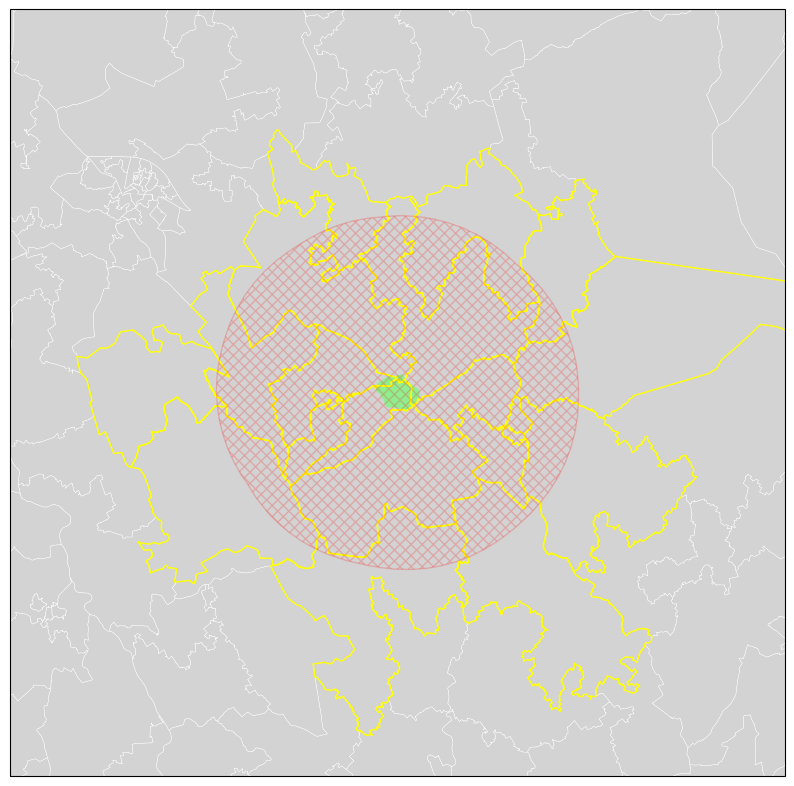

In [8]:

 
######################## Create output map to show ASSI, Buffer extent and Fields within Buffer extent ########################


# create the applicable CRS -in this case- Universal Transverse Mercator reference system- to transform the data
myCRS = ccrs.epsg(2157)


# create a figure of size 10x10 (representing the page size in inches)
myFig = plt.figure(figsize=(10, 10)) 

# create an axes object in the figure (within which the data shall be plotted), using the predefined crs
ax = plt.axes(projection=myCRS)  

# first, we set the map extent
xmin, ymin, xmax, ymax = ASSI.total_bounds #then get this dataset bounds and set them against the axes extent '
mapExtent = ax.set_extent([xmin-Dist_m_int-6500, xmax+Dist_m_int+6500, ymin-Dist_m_int-6500, ymax+Dist_m_int+6500], crs=myCRS)




#add towns  to give additional context
towns = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Towns.shp'))
towns.to_crs(epsg=2157, inplace=True)

###- - - - - - - - - - - - - - -  Add background features to map (for aesthetic/contest setting purposes only) - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -
if Selected_ASSI!='All':
     pass
else:
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=myCRS) # to add the town point data to map and create town handle for legend:
    # add the text labels for the towns
    for ind, row in towns.iterrows():  # towns.iterrows() returns the index and row
         x, y = row.geometry.x, row.geometry.y  # get the x,y location for each town
         ax.text(x, y, row['TOWN_NAME'].title(), fontsize=8, transform=myCRS)  # use plt.text to place a label at x,y
    
###- - - - - - - - - - - - - - -  Add required data to the map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -

#Create Shapely features to add to the map:
AgFields_feature = ShapelyFeature(AgFields['geometry'], myCRS, edgecolor='w', facecolor='lightgrey', linewidth=0.3)
ASSI_feature = ShapelyFeature(ASSI['geometry'], myCRS, edgecolor='none', facecolor='lightgreen', linewidth=1)
FieldsInBuf_feature = ShapelyFeature(FieldsInBuf['geometry'], myCRS, edgecolor='yellow', facecolor='none', linewidth=1)
ASSI_buffer_feature = ShapelyFeature(ASSI_buffer_dis['geometry'], myCRS, edgecolor='red', facecolor='none', hatch='xxx', alpha=0.2, linewidth=1)


#Add Shapely features to the map:
ax.add_feature(AgFields_feature)               # add the Field data to map
ax.add_feature(ASSI_feature)                   # add the ASSI data to map
ax.add_feature(FieldsInBuf_feature)            # add the Selected Field data to map
ax.add_feature(ASSI_buffer_feature)            # add selected ASSI 3km Buffer to map:
   


#add ASSI label to map-
#if Selected_ASSI=='All':    #too many to add,if looking at all (there are 394!)
     #pass
#else:                                           
    #ASSI["x"] = ASSI.centroid.map(lambda p: p.x) #this first requires x,yco-ords to be assigned to the feature(s)
    #ASSI["y"] = ASSI.centroid.map(lambda p: p.y)
    #for ind, row in ASSI.loc[ASSI['NAME'] == Selected_ASSI].iterrows():  # ASSI.iterrows() returns the index and row
        #x, y = row.x, row.y  # get the x,y location for each town
    #ax.text(x, y, row['NAME'].title(), fontsize=8, color ='red', transform=myCRS)  # use plt.text to place a label at x,y

#-----------------------------------------add gridlines:-----------------------------------------------------------------------

#gridlines = ax.gridlines(draw_labels=True,  # draw  labels for the grid lines
#                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],  # add longitude lines at 0.5 deg intervals
#                         ylocs=[54, 54.5, 55, 55.5])  # add latitude lines at 0.5 deg intervals
#gridlines.right_labels = False  # turn off the left-side labels
#gridlines.top_labels = False  # turn off the bottom labels
#gridlines.left_labels = True  # turn on the left-side labels
#gridlines.bottom_labels = True  # turn on the bottom labels


#-----------------------------add a north arrow:----------------------------------------------------------------------------------

#x, y, arrow_length = 0.93, 0.1, 0.075
#ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            #arrowprops=dict(facecolor="black", width=3.5, headwidth=15),
            #ha='center', va='center', fontsize=15,
            #xycoords=ax.transAxes)


   
#-----------------------------add a title and scalebar:--------------------------------------------------------------------------------    --
#if Selected_ASSI!='All':
     #ax.set_title("Fields Within/Partially Within " + str(Dist_km_int)+ "km of "+ Selected_ASSI +" ASSI")
     #scale_bar1()   
#else:
     #ax.set_title("Fields Within/Partially Within " + str(Dist_km_int)+ "km of an Area of Special Scientific Interest(ASSI)")
     #scale_bar2(ax)

################################################Create a map legend############################################################-

# generate a list of handles for the ASSI datasets
#ASSI_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgreen', edgecolor='lightgreen')]
#ASSI_buffer_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='red', hatch='xxx', alpha=0.2, linewidth=1)]
#AgField_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='w')]
#FieldsInBuf_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='yellow')]


#if Selected_ASSI!='All':
   # handles = ASSI_handles + ASSI_buffer_handles+  AgField_handles +FieldsInBuf_handles
   # labels = ['ASSI', (str(Dist_km_int))+'km Buffer','Field','Field Inside']
#else:
   # handles =  town_handle +  ASSI_handles + ASSI_buffer_handles+  AgField_handles +FieldsInBuf_handles
   # labels = ['Town', 'ASSI', (str(Dist_km_int))+'km Buffer','Field','Field Inside']


#leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                #fontsize=10, loc='upper left', frameon=True, framealpha=1)


#-----------------------------outputName:--------------------------------------------------------------------------------    --
#First To create a relevant filename (based on ASSI Reference) to use for saving ma, excel and shapefile outputs, first
ASSICode = str(FieldsInBuf.REFERENCE.unique())
ASSICode = ASSICode.replace("[", "")
ASSICode = ASSICode.replace("]", "")
ASSICode = ASSICode.replace("'","")


if Selected_ASSI!='All':
   OutputName =ASSICode+"_"+ str(Dist_km_int)+ "km_" + Selected_ASSI  #then use the ASSICode to create the prefix name for any output:
else:
   OutputName ="ALL_ASSI"+ str(Dist_km_int)+ "km" #then use the ASSICode to create the prefix name for any output:
 

#------------------------save the map, tabular and spatial output, to xlsx, png and shp respectively: ---------------------------------------------------------------------------------
myFig.savefig(OutputName+'_map.png', dpi=300, bbox_inches='tight')
print('Saving map image to ............'+str(OutputName)+'_map.png')


#Drop unrequired fields before exporting to excel
xlsx_FieldOutput = FieldsInBuf.drop(['geometry', 'index_right', 'OBJECTID', 'REFERENCE', 'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', 'HABITAT', 'EARTH_SCI', 'Area_km2_right', 'Length_m_right'], axis=1)
xlsx_FieldOutput= xlsx_FieldOutput.rename(columns={'Area_km2_left': 'Area_km2', 'Length_m_left': 'Length_m'})
xlsx_FieldOutput.to_excel(OutputName+"_Fields.xlsx") # exports the features to an excel file for future use (if required)
print('Saving tabular data to..........' +str(OutputName) +"_Fields.xlsx")
FieldsInBuf.to_file(OutputName+"_Fields.shp")
print('Saving spatial data to..........' +str(OutputName) +"_Fields.shp")
ASSI_buffer.to_file(OutputName+"_Buffer.shp")
print('Saving spatial data to..........' +str(OutputName) +"_Buffer.shp")

if Selected_ASSI=='All':
   pass
else:
    ASSI.to_file(ASSICode+ '_' +Selected_ASSI+"_ASSI.shp")
    print("Saving spatial data to.........."+ ASSICode+ '_' +Selected_ASSI+"_ASSI.shp")


#--------------------------------------Output stats to All text file------------------------------------------------------------------------
#Field Info
total_Area = AgFields.area.sum()/1000000# Total area of all fields
total_Area_inside = FieldsInBuf.area.sum()/1000000 # total area of fields falling within the BUFFER
total_Area_outside = total_Area -total_Area_inside # total area of fields falling outside the BUFFER

percentAllFields=total_Area/total_Area*100
percentFieldsInside=total_Area_inside/total_Area*100
percentFieldsOutside=100-percentFieldsInside

#Animal Info
NIPigCount=FieldInfo['Pig_Count'].sum()
NICattleCount=FieldInfo['Cattle_Count'].sum()
NIPoultryHouseCount =FieldInfo['PoultryHouses'].sum()

totalPigCount= FieldsInBuf['Pig_Count'].sum()
total_CattleCount= FieldsInBuf['Cattle_Count'].sum()
totalPoultryHouses= FieldsInBuf['PoultryHouses'].sum()

percentPigCount= totalPigCount/NIPigCount*100
percentCattleCount= total_CattleCount/NICattleCount*100
percentPoultryHouses= totalPoultryHouses/NIPoultryHouseCount*100

AvPigCount= FieldsInBuf['Pig_Count'].mean()
AvCattleCount= FieldsInBuf['Cattle_Count'].mean()
AvPoultyHouses= FieldsInBuf['PoultryHouses'].mean()


if Selected_ASSI =="All":
   Selected_ASSI = " an ASSI"
else:
    pass
    
print('Saving summary data to..........' +str(OutputName) + "_Results.txt")

with open(OutputName + "_Results.txt", "a") as f:
  print(OutputName + " Results ", file=f)
  print(" ", file=f)
  print(" ", file=f)
  print("Field Info:", file=f)
  print("Total area of all fields in NI is {:.0f} km2".format(total_Area), file=f)
  print("Total area of all fields falling within / partially within " +str(Dist_km_int)+"km of" +Selected_ASSI+":       {:.0f} km2 ({:.2f}%)".format(total_Area_inside,percentFieldsInside), file=f)
  print("Total area of all fields falling entirely outside of " +str(Dist_km_int)+"km from "+Selected_ASSI+":         {:.0f} km2 ({:.2f}%)".format(total_Area_outside,percentFieldsOutside), file=f)
  print(" ", file=f)
  print("Animal Info: ", file=f)
  print("Total count of pigs within/ partially within the " +str(Dist_km_int)+"km buffer:                 {:.0f} pigs ({:.2f}%)".format(totalPigCount,percentPigCount), file=f)
  print("Total count of cattle within/ partially within the " +str(Dist_km_int)+"km buffer:             {:.0f} cattle ({:.2f}%)".format(total_CattleCount, percentCattleCount), file=f)
  print("Total count of poultry houses within/ partially within the " +str(Dist_km_int)+"km buffer:        {:.0f} poultry houses ({:.2f}%)".format(totalPoultryHouses,percentPoultryHouses ), file=f)
  print(" ", file=f)
  print(" ", file=f)
  print("Mean number of pigs in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":                     {:.0f} pigs".format(AvPigCount), file=f)
  print("Mean number of cattle in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":                  {:.0f} cattle".format(AvCattleCount), file=f)
  print("Mean number of poultry houses in fields within/ partially within " +str(Dist_km_int)+"km of "+Selected_ASSI+":           {:.0f} poultry houses".format(AvPoultyHouses), file=f)
  print(" ", file=f)
  print(" ", file=f)  
  print(" ", file=f)
  print(" ", file=f) 
  print("Descriptive Statistics for fields within "+ str(Dist_km_int)+"km", file=f)
  print(" ", file=f) 
  print(FieldsInBuf.describe(),file=f)


print('The script has run successfully and created the following files:')
print('1 x Map File (png format)')
print('1 x Text File (txt format)')
print('1 x Workbook Map Output (xlsx format)')

if Selected_ASSI == " an ASSI":
    print('2 x Spatial File Outputs (shp format)')
else:
    print('3 x Spatial File Outputs (shp format)')

In [11]:
FieldsInBuf.geometry

530    POLYGON ((705180.982 915429.125, 705181.888 91...
557    POLYGON ((704704.615 915352.426, 704710.770 91...
571    POLYGON ((707359.405 918881.901, 707356.531 91...
641    POLYGON ((708992.530 926241.931, 708998.341 92...
642    POLYGON ((715880.092 923024.994, 715885.715 92...
653    POLYGON ((707208.034 919356.268, 707209.034 91...
654    POLYGON ((703838.166 919165.983, 703842.446 91...
655    POLYGON ((706325.825 920640.590, 706326.262 92...
656    POLYGON ((707368.275 918258.348, 707363.058 91...
661    POLYGON ((703309.784 919974.312, 703159.409 91...
662    POLYGON ((698229.303 923406.943, 698227.647 92...
663    POLYGON ((703309.784 919974.312, 703310.627 91...
664    POLYGON ((700837.687 919112.323, 700833.375 91...
665    POLYGON ((701644.202 919279.065, 701642.921 91...
674    POLYGON ((698495.219 918438.512, 698495.594 91...
675    POLYGON ((693283.354 920690.680, 693314.535 92...
682    POLYGON ((703009.534 925552.799, 703013.127 92...
683    POLYGON ((699274.566 927

In [13]:
ASSI_buffer.wkt


AttributeError: 'GeoDataFrame' object has no attribute 'wkt'

In [ ]:
ASSI.to_file

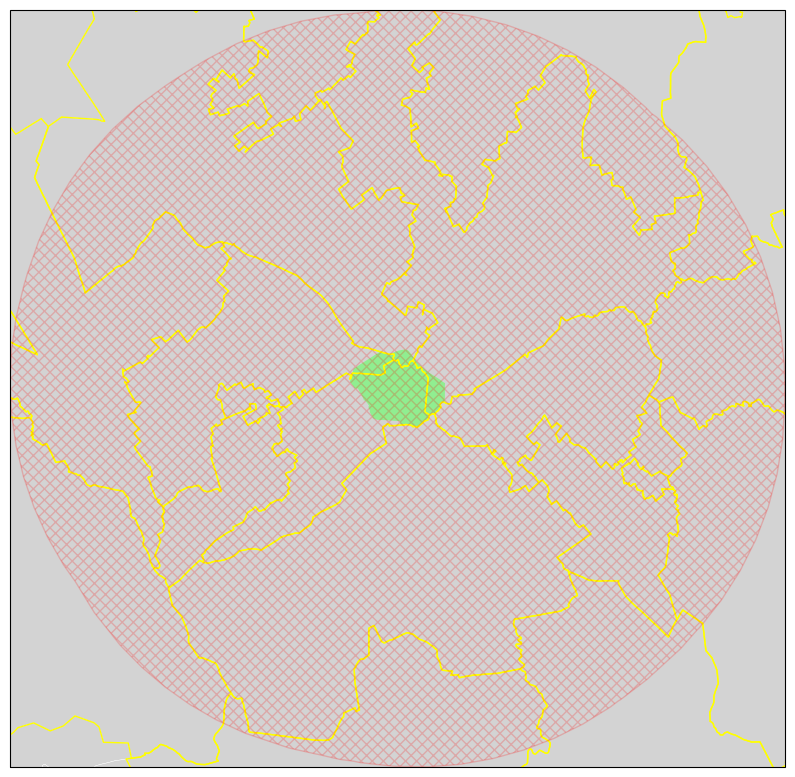

In [9]:
mapExtent = ax.set_extent([xmin-Dist_m_int, xmax+Dist_m_int, ymin-Dist_m_int, ymax+Dist_m_int], crs=myCRS)
myFig